In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.fc = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# 设置随机种子
seed = 42
torch.manual_seed(seed)

# 加载 MNIST 训练数据集和测试数据集
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])
mnist_train = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)

# 数据集划分
generator = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = torch.utils.data.random_split(mnist_train, [50000, 10000], generator=generator)

# 选择十个标签已知的图像
labeled_indices = [1173, 3336, 12529, 12785, 12979, 17351, 27048, 40579, 43128, 46498]
labeled_images = [train_dataset[idx][0].numpy().flatten() for idx in labeled_indices]
ground_truth_label = [train_dataset[idx][1] for idx in labeled_indices]
print(ground_truth_label)

# 转换为 NumPy 数组
labeled_images = np.array(labeled_images)

# 使用 PCA 进行降维
pca = PCA(n_components=10)  # 选择64维作为降维后的特征
labeled_images_pca = pca.fit_transform(labeled_images)
# 获取降维后的 MNIST 图像数据集
mnist_images = [train_dataset[i][0].numpy().flatten() for i in range(len(train_dataset))]
mnist_images = np.array(mnist_images)
mnist_images_pca = pca.transform(mnist_images)
# 计算每个图像与标签已知图像的相似度
similarities = np.dot(mnist_images_pca, labeled_images_pca.T)

# 对每个标签已知图像选择最相似的一部分图像
num_similar_images = 2000  # 选择最相似的100张图像作为训练集
train_indices = []
for i in range(len(labeled_indices)):
    label_indices = np.argsort(similarities[:, i])[::-1][:num_similar_images]
    print(i," ",len(label_indices)," ",max(label_indices))
    train_indices.extend(label_indices)

# 构建训练集的数据加载器
train_dataset_s = torch.utils.data.Subset(train_dataset, train_indices)
train_loader_s = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# 打印训练集的标签分布
# train_labels = [train_dataset_s[idx][1] for idx in train_indices]
# unique_labels, counts = np.unique(train_labels, return_counts=True)
# for label, count in zip(unique_labels, counts):
    # print(f"Label {label}: Sample Count {count}")


100%|██████████| 9912422/9912422 [00:00<00:00, 85733898.99it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43573990.58it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21950959.96it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13636742.14it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

[4, 7, 0, 9, 8, 3, 6, 2, 5, 1]
0   2000   49990
1   2000   49977
2   2000   49949
3   2000   49991
4   2000   49992
5   2000   49979
6   2000   49909
7   2000   49973
8   2000   49933
9   2000   49986


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)
        return out

# 定义深层卷积神经网络
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

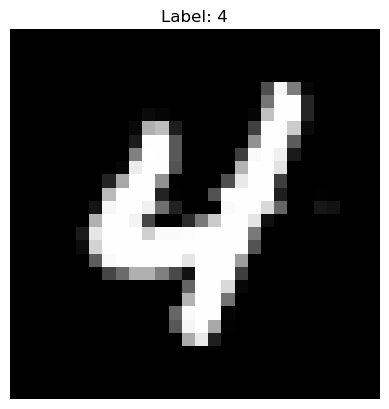

In [5]:
# 选择要展示的图像的索引，随便输，这个我只是验证train_dataset_s用的
index = 1

# 获取图像和标签
image, label = train_dataset_s[index]

# 将图像转换为 NumPy 数组
image = image.numpy()

# 显示图像
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [9]:
# 在验证集上验证
# 定义训练参数
batch_size = 32
lr = 0.001
num_epochs = 15

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(28)
])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 创建模型并将其移到GPU上（如果可用）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = CNN().to(device)
model=ResNet(num_classes=10).to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_draw=[]
accuracy_draw=[]
# 训练和验证
for epoch in range(num_epochs):
    # 训练模型
    model.train()
    for images, labels in train_loader_s:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    loss_draw.append(loss)
    # 在验证集上进行验证
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    accuracy_draw.append(accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {accuracy:.2f}%")
    

Epoch [1/15], Validation Accuracy: 97.84%
Epoch [2/15], Validation Accuracy: 98.18%
Epoch [3/15], Validation Accuracy: 97.59%
Epoch [4/15], Validation Accuracy: 98.66%
Epoch [5/15], Validation Accuracy: 98.73%
Epoch [6/15], Validation Accuracy: 98.94%
Epoch [7/15], Validation Accuracy: 98.73%
Epoch [8/15], Validation Accuracy: 98.78%
Epoch [9/15], Validation Accuracy: 99.24%
Epoch [10/15], Validation Accuracy: 98.78%
Epoch [11/15], Validation Accuracy: 99.08%
Epoch [12/15], Validation Accuracy: 99.32%
Epoch [13/15], Validation Accuracy: 99.08%
Epoch [14/15], Validation Accuracy: 99.20%
Epoch [15/15], Validation Accuracy: 99.23%


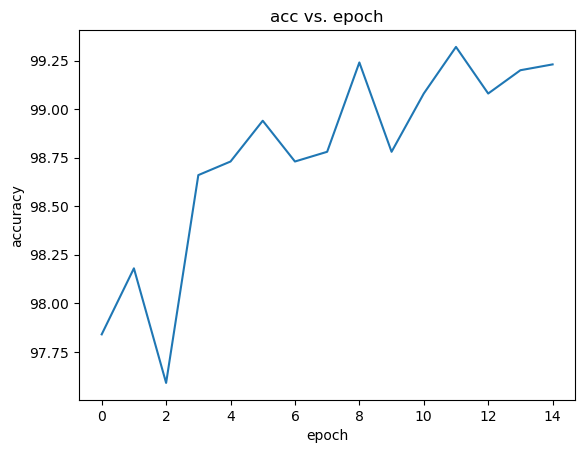

In [10]:
# plot function
def plot_two_graphs(x, y, z):
    # 创建画布和子图
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # 绘制第一个图
    ax1.plot(x, y)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('loss vs. epoch')

    # 绘制第二个图
    ax2.plot(x, z)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.set_title('acc vs. epoch')

    # 调整子图之间的间距
    plt.tight_layout()

    # 显示图形
    plt.show()
# print(range(num_epochs))
# print(loss_draw)
# print(accuracy_draw)
# plot_two_graphs(range(num_epochs),loss_draw,accuracy_draw)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('acc vs. epoch')
plt.plot(range(num_epochs),accuracy_draw)
plt.show()



In [12]:
# 在测试集上进行测试
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=True)
model.eval()  # 将模型设置为评估模式
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 前向传播
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # 统计预测结果
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

# 计算准确率
accuracy = 100 * total_correct / total_samples
print(f'在测试集上的准确率：{accuracy:.2f}%')

在测试集上的准确率：99.23%
